In [2]:
import pandas as pd
from scipy.stats import pearsonr,spearmanr
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.spatial.distance as sp
import numpy as np
import sys
import csv
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import statsmodels.api as sm
from matlab.engine import MatlabExecutionError
from sklearn.linear_model import LinearRegression, MultiTaskLasso, Lasso, Ridge, ElasticNet, MultiTaskElasticNet,BayesianRidge
from scipy.stats.mstats import zscore

import mpld3
from mpld3 import plugins
mpld3.enable_notebook()
%run Utilities.ipynb
%matplotlib inline

### Files needed to run the scripts
Data
- cdr_features.pickle
- env_features.csv

Poverty Targets (A - Intensity of Poverty, H - incidence of Poverty, MPI - multidimensional poverty index)
- census_commune_A.pickle # file containing information about communes and their poverty intensities.
- census_commune_H.pickle  # file containing information about communes and their incidence of poverty.
- census_commune_MPI.pickle # file containing information about communes and their poverty values.

Auxillary Data
- com_distances.csv # distance between every pair of communes in Senegal
- communes_urban_rural.csv # communes classified as urban or rural - information obtained from Senegal. 
- urban_rural_points.csv # information about the latitude and longitude of the urban centers in Senegal

In [3]:
# load com2com distance matrix - Distance between communes
map_distances = {}
commune_ids = []
with open('./com_distances.csv','r') as f:
    r = csv.reader(f)
    r.next()
    for row in r:
        c1 = str(int(row[0])).zfill(8)
        if c1 not in commune_ids:
            commune_ids.append(c1)
        c2 = str(int(row[1])).zfill(8)
        map_distances[(c1,c2)] = float(row[2])


In [4]:
# creating reg2com_map - Mapping from regions to communes
reg2com_map = {}
for i in commune_ids:
    r = i[0:2]
    if r not in reg2com_map.keys():
        reg2com_map[r] = []
    reg2com_map[r].append(i)  

In [5]:
# load cdr features
map_feature_allmonths_com = pickle.load(open('./cdr_features.pickle'))

In [6]:
# load environmental features
map_feature_env_com = {}
with open('./env_features.csv','r') as f:
    reader = csv.reader(f)
    featurenames = reader.next()[1:]
    for row in reader:
        if len(np.where(np.array(row[1:])=='NA')[0]) < 5:
            c = int(row[0])
            map_feature_env_com[str(c).zfill(8)] = row[1:]
# remove columns with any NA value - 
yy = np.array(map_feature_env_com.values())
nainds = np.where(np.any(yy == 'NA',axis=0))[0]
# remove columns with all zeros
zinds = np.where(np.all(yy == '0',axis=0))
for c in map_feature_env_com.keys():
    selectedfeaturenames = []
    r = map_feature_env_com[c]
    r1 = []
    for i in range(len(r)):
        if i not in nainds and i not in zinds:
            r1.append(r[i])
            selectedfeaturenames.append(featurenames[i])
    map_feature_env_com[c] = r1

In [7]:
com_A = pickle.load(open('./census_commune_A.pickle'))
com_H = pickle.load(open('./census_commune_H.pickle'))
com_MPI = pickle.load(open('./census_commune_mpi.pickle'))

### PREPARE DATA

In [19]:
# for multiple habitat deprivations and individual indicators and environmental indicators
common_com = []
for c in map_feature_allmonths_com.keys():
    if c in map_feature_env_com and c in com_MPI:
        common_com.append(c)

In [38]:
urban_communes = []
with open('./communes_urban_rural.csv','r') as f:
    fr = csv.reader(f)
    fr.next()
    for row in fr:
        if row[3] == 'urban':
            urban_communes.append(str(int(row[1])).zfill(8))

In [12]:
# load spatial coordinates
map_communes_coords = {}
with open('./urban_rural_points.csv','r') as f:
    fr = csv.reader(f)
    fr.next()
    for row in fr:
        map_communes_coords[row[0]] = [float(row[1]),float(row[2])]

In [21]:
# for household deprivations and individual indicators
numcdrfeatures = 43*12
numenvfeatures = len(selectedfeaturenames)

inds1 = range(4) #choose only education and health deprivations from all
inds2 = range(6) #choose from standard of living deprivations
x = np.zeros([len(common_com),numcdrfeatures+numenvfeatures])
s = np.zeros([len(common_com),2])
y_ha = np.zeros([len(common_com),2])
mpi = np.zeros([len(common_com)])
i = 0
for c in common_com:
    x[i,0:numcdrfeatures] = map_feature_allmonths_com[c]
    x[i,numcdrfeatures:(numcdrfeatures+numenvfeatures)] = map_feature_env_com[c]
    s[i,0] = map_communes_coords[c][0] # lon
    s[i,1] = map_communes_coords[c][1] # lat
    y_ha[i,0] = (com_H[c])
    y_ha[i,1] = (com_A[c])
    mpi[i] = com_MPI[c]
    i = i + 1
norm_x = zscore(x)
s = zscore(s)

In [22]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(eng.genpath(r'./gpml'),nargout=0)

### Evaluate different models

In [30]:
lmbd = 0.3
niters = 20
args = {}
args['eng'] = eng
args['mpi'] = mpi
args['s'] = s
args['view2index'] = numcdrfeatures

#method = 'MultiViewGPR','Elastic','Mixed','MultiViewGPRSpatial','Kriging'
# to run cdr or environ only - use mixed
method = 'MultiViewGPR'
print method

pcorrvec,ppvalvec,scorrvec,spvalvec,rmsevec,map_YPreds,map_Yvar1,map_Yvar2,map_Yvar_combined = crossvalidate_spatial(norm_x,y_ha,lmbd,niters,method,args,common_com,map_distances,reg2com_map)
#pcorrvec,ppvalvec,scorrvec,spvalvec,rmsevec,map_YPreds,map_Yvar1,map_Yvar2,map_Yvar_combined = crossvalidate_standard(norm_x,y_ha,lmbd,niters,method,args)

pretty_print(np.mean(pcorrvec,axis=0))
pretty_print(np.std(pcorrvec,axis=0))
print(np.mean(ppvalvec,axis=0))
print "\n"
pretty_print(np.mean(scorrvec,axis=0))
pretty_print(np.std(scorrvec,axis=0))
print(np.mean(spvalvec,axis=0))
print "\n"
pretty_print(np.mean(rmsevec,axis=0))
pretty_print(np.std(rmsevec,axis=0))

MultiViewGPR
Validation run 4 of 20
Validation run 8 of 20
Validation run 12 of 20
Validation run 16 of 20
00.93 00.87 00.93
00.05 00.05 00.05
[  9.71407941e-63   2.54584544e-56   5.17287224e-66]


00.88 00.86 00.89
00.07 00.06 00.06
[  9.17771992e-48   2.49590061e-46   3.05359323e-54]


12.32 04.72 00.09
04.11 00.92 00.01


In [31]:
## Combining predicted means for each run to get average predictions for each commune
map_ComIndPreds = {}
for _l  in range(len(map_YPreds)):
    #_l gives the index of the crossvalidation run
    for _j in range(len(map_YPreds[_l][0])):
        #_j gives the index of a commune
        _com_id = common_com[map_YPreds[_l][0][_j]]
        if _com_id not in map_ComIndPreds.keys():
            map_ComIndPreds[_com_id] = []
        map_ComIndPreds[_com_id].append(map_YPreds[_l][1][_j])

map_ComIndMeanPreds = {}
for c in map_ComIndPreds.keys():
    v = np.array(map_ComIndPreds[c])
    map_ComIndMeanPreds[c] = np.mean(v,axis=0)

In [32]:
## Combining predicted Variances for each run to get average variance prediction for each commune
map_ComIndVars = {}
for _l  in range(len(map_Yvar_combined)):
    #_l gives the index of the crossvalidation run
    for _j in range(len(map_Yvar_combined[_l][0])):
        #_j gives the index of a commune
        _com_id = common_com[map_Yvar_combined[_l][0][_j]]
        if _com_id not in map_ComIndVars.keys():
            map_ComIndVars[_com_id] = []
        map_ComIndVars[_com_id].append(map_Yvar_combined[_l][1][_j])

map_ComIndMeanVars = {}
for c in map_ComIndVars.keys():
    v = np.array(map_ComIndVars[c])
    map_ComIndMeanVars[c] = np.mean(v,axis=0)

In [33]:
map_ComIndMeanPreds = fillMissingCommunes(map_ComIndMeanPreds,commune_ids)
map_ComIndMeanVars = fillMissingCommunes(map_ComIndMeanVars,commune_ids)

In [34]:
## Combining variances for each run to get average variance for each commune
## This is to compare the impact of CDR vs. ENV over each commune
map_ComIndVars1 = {}
map_ComIndVars2 = {}
for _l  in range(len(map_Yvar1)):
    #_l gives the index of the crossvalidation run
    for _j in range(len(map_Yvar1[_l][0])):
        #_j gives the index of a commune
        _com_id = common_com[map_Yvar1[_l][0][_j]]
        if _com_id not in map_ComIndVars1.keys():
            map_ComIndVars1[_com_id] = []
            map_ComIndVars2[_com_id] = []

        map_ComIndVars1[_com_id].append(np.sqrt(map_Yvar1[_l][1][_j]))
        map_ComIndVars2[_com_id].append(np.sqrt(map_Yvar2[_l][1][_j]))

map_ComIndMeanVars1 = {}
map_ComIndMeanVars2 = {}
for c in map_ComIndVars1.keys():
    v = np.array(map_ComIndVars1[c])
    map_ComIndMeanVars1[c] = np.mean(v,axis=0)
for c in map_ComIndVars2.keys():
    v = np.array(map_ComIndVars2[c])
    map_ComIndMeanVars2[c] = np.mean(v,axis=0)


In [35]:
map_ComIndMeanVars1 = fillMissingCommunes(map_ComIndMeanVars1,commune_ids)
map_ComIndMeanVars2 = fillMissingCommunes(map_ComIndMeanVars2,commune_ids)

### Scatter Plot

In [36]:
# get variances with predicted MPI 
# assuming that H and A are independent of each other
map_ComIndMPIVars = {}
for c in commune_ids:
    _vh = map_ComIndMeanVars[c][0]
    _va = map_ComIndMeanVars[c][1]
    _mh = map_ComIndMeanPreds[c][0]
    _ma = map_ComIndMeanPreds[c][1]
    _vmpi = (_vh*_va + _vh*_mh*_mh + _va*_ma*_ma)*10e-8
    map_ComIndMPIVars[c] = _vmpi

In [39]:
# for generating scatter plot for MPI
n_com_MPI = fillMissingCommunes(com_MPI,commune_ids)
vals = []
ur = []
vs = []
for c in commune_ids:
    vals.append([n_com_MPI[c],map_ComIndMeanPreds[c][2]])
    vs.append(map_ComIndMPIVars[c])
    if c in urban_communes:
        ur.append(1)
    else:
        ur.append(2)
vals = np.array(vals)
vs = np.array(vs)

In [40]:
mpl.rcParams['font.size'] = 28

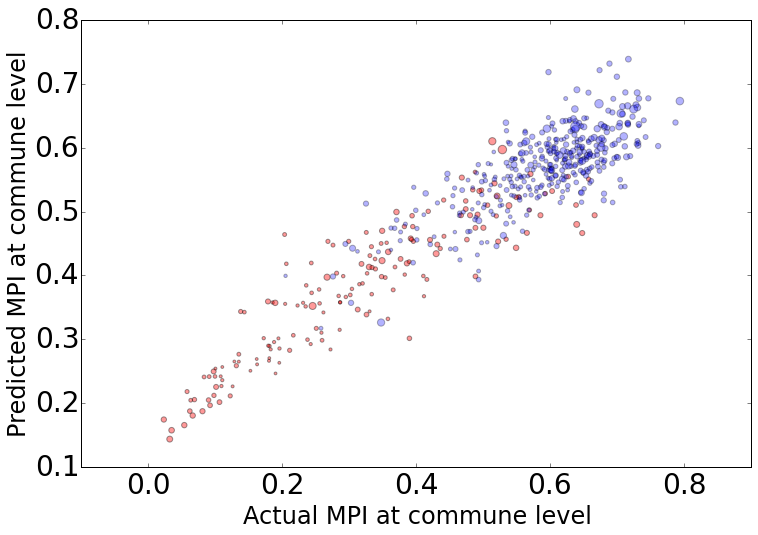

In [45]:
fig, ax = plt.subplots(figsize=[12,8])

uinds = np.where(np.array(ur) == 1)[0]
rinds = np.where(np.array(ur) == 2)[0]
ax.scatter(vals[uinds,0],vals[uinds,1],alpha=0.4,c='r',s=500*((vs[uinds])))
ax.scatter(vals[rinds,0],vals[rinds,1],alpha=0.3,c='b',s=500*((vs[rinds])))
plt.xlabel('xlabel', fontsize=24)
plt.ylabel('ylabel', fontsize=24)
ax.set_xlabel('Actual MPI at commune level')
ax.set_ylabel('Predicted MPI at commune level')